In [0]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import unicodedata

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import nltk
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,SpatialDropout1D,SpatialDropout2D

### Data is available at http://mlg.ucd.ie/datasets/bbc.html

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import os

data_dir = "/content/drive/My Drive/Projects/bbc_news/"
print(os.listdir(data_dir))
bbc_data_file_name = "bbc_news_data.csv"

['bbc_news_data.csv', 'BBC-News.ipynb']


In [0]:
if(not os.path.exists(os.path.join(data_dir,bbc_data_file_name))):
  print("exists")
  category_map={}
  for category in os.listdir(data_dir):
    path,dir,files = next(os.walk(data_dir+category))
    category_map[category] = len(files)

  print(category_map)
  f = open("bbc_news/business/001.txt", "r")
  print(f.read().replace("\n"," "))

  sentences = []
  labels = []
  for category in os.listdir(data_dir):
    category_dir = os.path.join(data_dir,category)
    path,dir,files = next(os.walk(category_dir))
    for file in files:
        file_path = os.path.join(category_dir,file)
        #print(file_path)
        sentence = open(file_path, "r")
        sentences.append(sentence.read().replace("\n"," "))
        labels.append(category)
  bbc_news_data = pd.DataFrame({"category":labels,'text':sentences})
  bbc_news_data.to_csv("bbc_news_data.csv",index=False, header=True)
        
    

In [0]:
bbc_news_df = pd.read_csv(os.path.join(data_dir,bbc_data_file_name))

In [10]:
bbc_news_df.sample(5)

category                                               text
1170       politics  Howard dismisses Tory tax fears  Michael Howar...
389        business  Wal-Mart to pay $14m in gun suit  The world's ...
526   entertainment  Spark heads world Booker list  Dame Muriel Spa...
2221           tech  Spam e-mails tempt net shoppers  Computer user...
2051           tech  More power to the people says HP  The digital ...

### Performing Exploratory Data Analysis

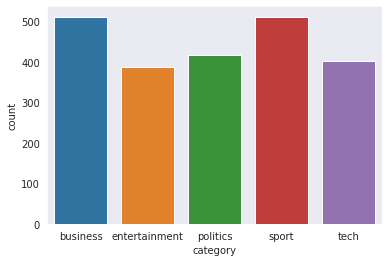

In [11]:
sns.set_style("dark")
sns.countplot(bbc_news_df.category)

In [12]:
bbc_news_df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

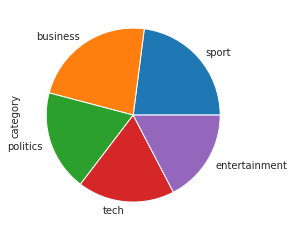

In [13]:
bbc_news_df.category.value_counts().plot(kind='pie')

In [14]:
# The unique characters in the file
vocab = sorted(set(bbc_news_df['text'].map(lambda c : c.lower()).str.cat()))
print ('{} unique characters'.format(len(vocab)))

62 unique characters


In [15]:
print(vocab)

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', 'â']


## Text Pre Processing

## We can see 62 unique characters
### We have to derive strategy to deal with them

### Removing accented characters

Usually in any text corpus, you might be dealing with accented characters/letters, especially if you only want to analyze the English language. Hence, we need to make sure that these characters are converted and standardized into ASCII characters. A simple example — converting é to e

In [16]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

### Expanding Contractions

Contractions are shortened version of words or syllables. They often exist in either written or spoken forms in the English language. These shortened versions or contractions of words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. Examples would be, **do not** to **don’t** and **I would** to I’d. Converting each contraction to its expanded, original form helps with text standardization.

In [0]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [18]:
def expand_contractions(text,contraction_mapping=CONTRACTION_MAP):
  contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
  def expand_match(contraction):
        
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
  expanded_text = contractions_pattern.sub(expand_match, text)
  return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

### Removing Special Characters

Special characters and symbols are usually non-alphanumeric characters or even occasionally numeric characters (depending on the problem), which add to the extra noise in unstructured text. Usually, simple regular expressions (regexes) can be used to remove them.

In [19]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

### **Removing Stopwords**

Words which have little or no significance, especially when constructing meaningful features from text, are known as stopwords or stop words. These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus. Typically, these can be articles, conjunctions, prepositions and so on. Some examples of stopwords are a, an, the, and the like.

In [20]:
nltk.download('stopwords')
stopword_list = set(stopwords.words('english'))
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
toktokTokenizer = ToktokTokenizer()

In [22]:
def remove_stopwords(text, is_lower_case=False):
    tokens = toktokTokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

### **Stemming**


To understand stemming, you need to gain some perspective on what word stems represent. Word stems are also known as the base form of a word, and we can create new words by attaching affixes to them in a process known as inflection. Consider the word JUMP. You can add affixes to it and form new words like JUMPS, JUMPED, and JUMPING. In this case, the base word JUMP is the word stem.

### **Lemmatization**

Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem. The difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Thus, root word, also known as the lemma, will always be present in the dictionary. Both nltk and spacy have excellent lemmatizers. We will be using spacy here.

In [23]:
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

/bin/bash: {sys.executable}: command not found


In [24]:
nlp = spacy.load('en', parse=True, tag=True, entity=True)
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

### Building a Text Normalizer

In [0]:
def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # Converting words to their lemma form
        if text_lemmatization:
          doc = lemmatize_text(doc)
        
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [0]:
bbc_news_df['clean_text'] = normalize_corpus(bbc_news_df['text'])
#bbc_news_df['clean_text'] = bbc_news_df['text'].apply(normalize_corpus)

In [25]:
print(bbc_news_df['text'][0])

Ad sales boost Time Warner profit  Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AO

In [32]:
print(bbc_news_df['clean_text'][0])

ad sale boost time warner profit quarterly profit us media giant timewarner jump bn three month december year earlier firm one big investor google benefit sale high speed internet connection high advert sale timewarner say fourth quarter sale rise bn bn profit buoy one gain offset profit dip warner bros less user aol time warner say friday search engine google internet business aol mix fortune lose subscriber fourth quarter profit low precede three quarter however company say aol underlying profit exceptional item rise back strong internet advertising revenue hope increase subscriber offer online service free timewarner internet customer try sign aol exist customer high speed broadband timewarner also restate result follow probe us securities exchange commission sec close conclude time warner fourth quarter profit slightly well analyst expectation film division see profit slump help box office flop alexander catwoman sharp contrast year earlier third final film lord ring trilogy boost 

In [33]:
bbc_news_df.clean_text

0       ad sale boost time warner profit quarterly pro...
1       dollar gain greenspan speech dollar hit high l...
2       yukos unit buyer face loan claim owner embattl...
3       high fuel price hit ba profit british airways ...
4       pernod takeover talk lift domecq share uk drin...
                              ...                        
2220    bt program beat dialler scam bt introduce two ...
2221    spam e mail tempt net shopper computer user ac...
2222    careful code new european directive could put ...
2223    us cyber security chief resign man make sure u...
2224    lose online gaming online role playing game ti...
Name: clean_text, Length: 2225, dtype: object

### Creating Word cloud - Most frequently words will be displaced

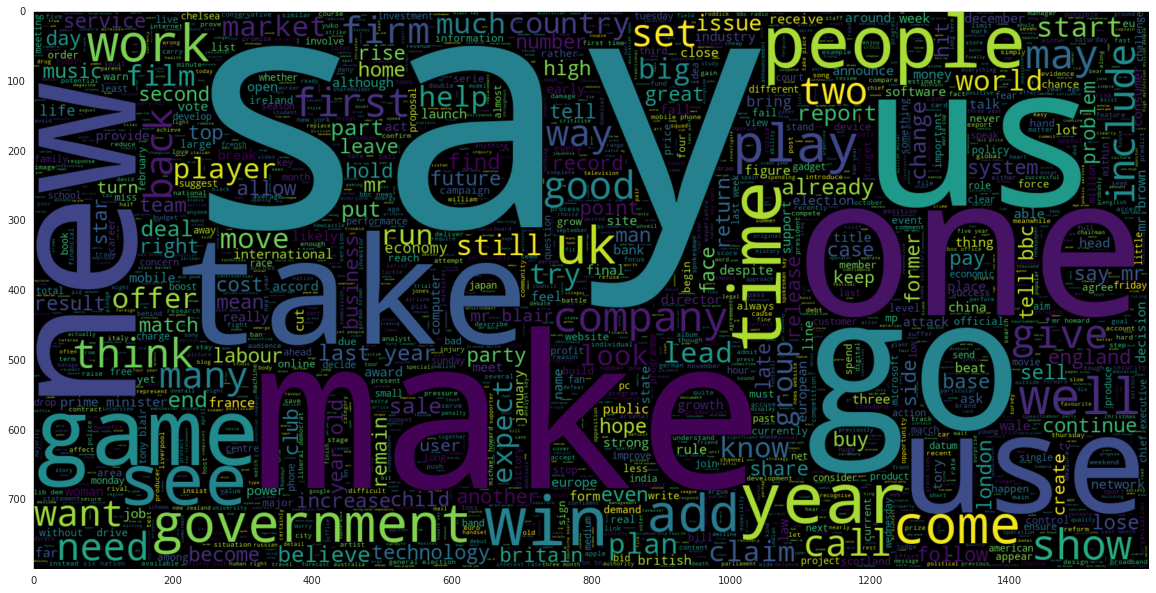

In [34]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(bbc_news_df.clean_text))
plt.imshow(wc , interpolation = 'bilinear')

### Creating Word cloud - Considering only Business News

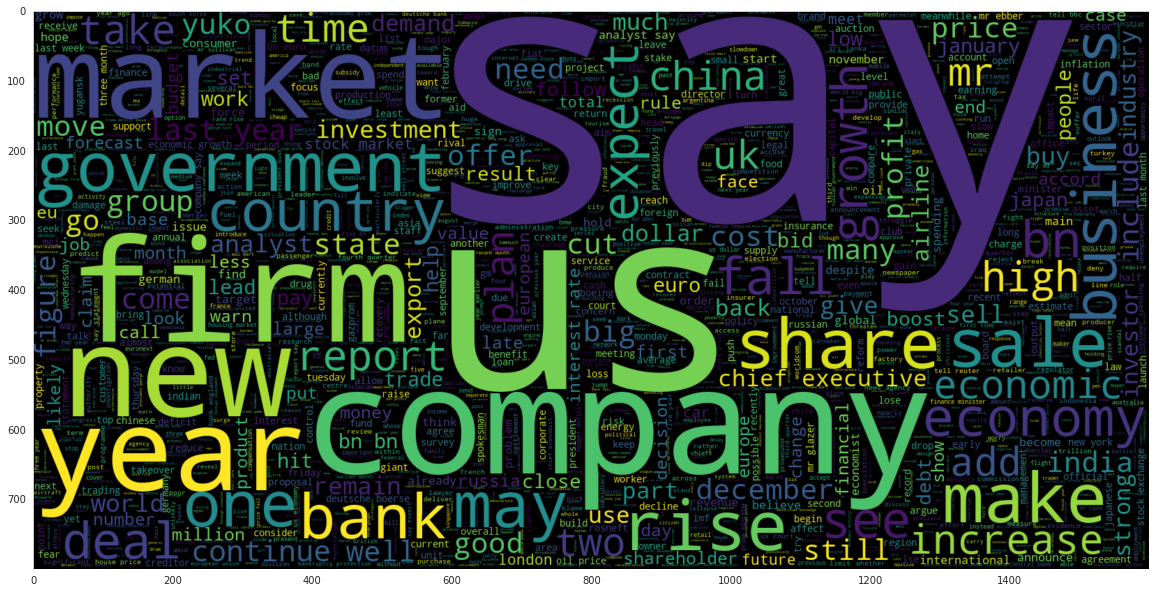

In [35]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(bbc_news_df[bbc_news_df.category=='business'].clean_text))
plt.imshow(wc , interpolation = 'bilinear')

### Observation

### We can see from above image that it contains business terma such as ***Market, company , firm , bank*** etc

### Creating Word cloud - Considering only Technology News

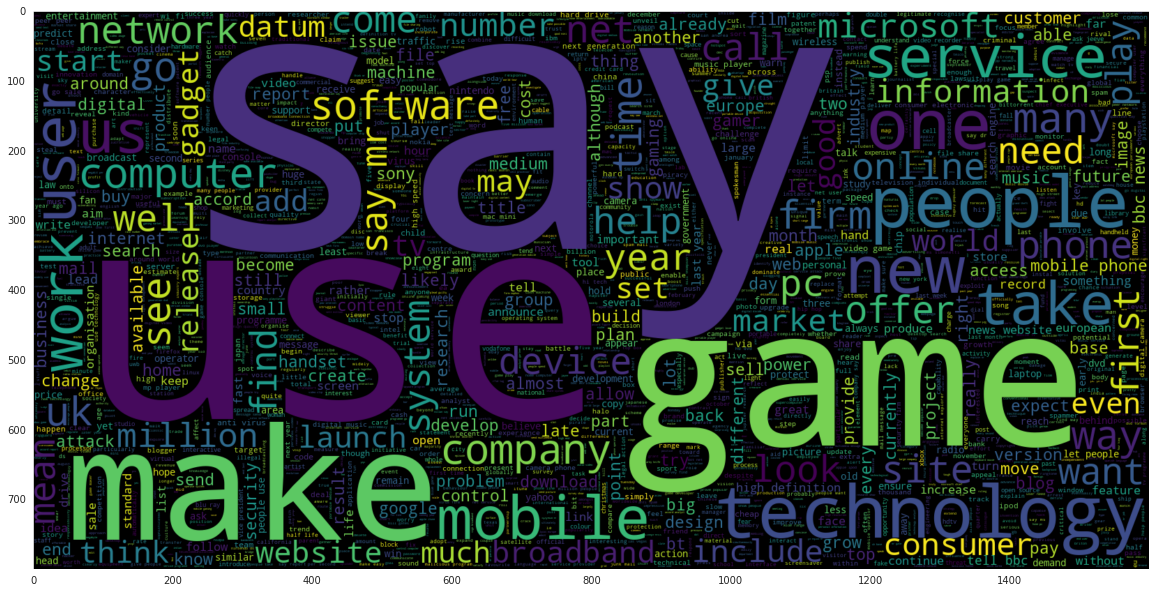

In [36]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(bbc_news_df[bbc_news_df.category=='tech'].clean_text))
plt.imshow(wc , interpolation = 'bilinear')

### Observation

### We can see from above image that it contains business terma such as ***game, technology,software,computer*** etc

In [37]:
bbc_news_df.clean_text[2224]

'lose online gaming online role playing game time consume enthral flight reality people take fantasy live seriously video game world warcraft hit shop europe last week fan write bbc website express delight offer warning addiction game like far costly time substance could impair keep track time write travis anderson texas comment humorous game good not go get no way could limit hour would spend play write charles macintyre england strike worrying tone massively multiplayer online role playing game mmorpg need get could motto mmorpg shame get popular know problem go mushroom write stuart stanton davy huddersfield scare monger article addictive video game exist since day first game pong stop everyone work atari office gaming like pastime quickly become unhealthy obsession whether spend much time gym front television read poetry unfortunately gaming addiction far easy association make however story gamer spend hour day front video game become frequent impact family quite distressing massiv

In [38]:
bbc_news_df.clean_text.apply(len)

0       1666
1       1517
2       1053
3       1607
4       1056
        ... 
2220    1652
2221    1503
2222    3961
2223    1552
2224    9551
Name: clean_text, Length: 2225, dtype: int64

### Building Model

In [0]:
vocab_size = 18000
embedding_dim = 50
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8  

In [0]:
x_train, x_test, y_train, y_test = train_test_split(bbc_news_df.clean_text, bbc_news_df.category , test_size = 0.3 , random_state = 0) 

In [81]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))
print(train_padded.shape)

109
150
271
150
202
150
(1557, 150)


In [82]:
word_index

{'<OOV>': 1,
 'say': 2,
 'not': 3,
 'year': 4,
 'mr': 5,
 'would': 6,
 'make': 7,
 'also': 8,
 'us': 9,
 'people': 10,
 'new': 11,
 'one': 12,
 'take': 13,
 'go': 14,
 'get': 15,
 'good': 16,
 'time': 17,
 'could': 18,
 'use': 19,
 'win': 20,
 'game': 21,
 'last': 22,
 'first': 23,
 'two': 24,
 'government': 25,
 'world': 26,
 'come': 27,
 'see': 28,
 'film': 29,
 'show': 30,
 'play': 31,
 'company': 32,
 'uk': 33,
 'tell': 34,
 'work': 35,
 'firm': 36,
 'well': 37,
 'no': 38,
 'want': 39,
 'back': 40,
 'add': 41,
 'give': 42,
 'like': 43,
 'may': 44,
 'number': 45,
 'service': 46,
 'think': 47,
 'month': 48,
 'country': 49,
 'music': 50,
 'include': 51,
 'set': 52,
 'party': 53,
 'many': 54,
 'way': 55,
 'high': 56,
 'plan': 57,
 'three': 58,
 'labour': 59,
 'need': 60,
 'market': 61,
 'report': 62,
 'week': 63,
 'home': 64,
 'election': 65,
 'player': 66,
 'big': 67,
 'look': 68,
 'next': 69,
 'call': 70,
 'bbc': 71,
 'minister': 72,
 'bn': 73,
 'sale': 74,
 'million': 75,
 'know': 7

Sample vocabularry is like {'< OOV >': 1,
 'say': 2,
 'not': 3,
 'year': 4,
 'mr': 5,
 'would': 6,
 'make': 7,
 'also': 8,...

In [78]:
validation_sequences = tokenizer.texts_to_sequences(x_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)
print(len(validation_sequences))
print(validation_padded.shape)

668
(668, 150)


In [43]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(bbc_news_df.category)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

print(training_label_seq.shape)
print(validation_label_seq.shape)

training_label_seq[0]

(1557, 1)
(668, 1)


array([1])

In [44]:
type(training_label_seq)

numpy.ndarray

In [45]:
label_tokenizer.word_index

{'business': 2, 'entertainment': 5, 'politics': 3, 'sport': 1, 'tech': 4}

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(units=128))
model.add(Dense(24, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 50)           1250000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 50)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 1,344,894
Trainable params: 1,344,894
Non-trainable params: 0
_________________________________________________________________


In [55]:
num_epochs = 15
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/15
49/49 - 10s - loss: 1.6540 - accuracy: 0.2582 - val_loss: 1.5488 - val_accuracy: 0.2620
Epoch 2/15
49/49 - 9s - loss: 1.5013 - accuracy: 0.3475 - val_loss: 1.7636 - val_accuracy: 0.2650
Epoch 3/15
49/49 - 9s - loss: 1.5939 - accuracy: 0.2723 - val_loss: 1.5378 - val_accuracy: 0.3129
Epoch 4/15
49/49 - 9s - loss: 1.4359 - accuracy: 0.4502 - val_loss: 1.6235 - val_accuracy: 0.2440
Epoch 5/15
49/49 - 9s - loss: 1.3162 - accuracy: 0.4387 - val_loss: 1.6070 - val_accuracy: 0.3533
Epoch 6/15
49/49 - 9s - loss: 1.0399 - accuracy: 0.5909 - val_loss: 1.0718 - val_accuracy: 0.5539
Epoch 7/15
49/49 - 9s - loss: 0.7865 - accuracy: 0.7219 - val_loss: 0.9169 - val_accuracy: 0.6003
Epoch 8/15
49/49 - 9s - loss: 0.7497 - accuracy: 0.7431 - val_loss: 1.1572 - val_accuracy: 0.5659
Epoch 9/15
49/49 - 9s - loss: 0.4741 - accuracy: 0.8651 - val_loss: 0.7437 - val_accuracy: 0.7470
Epoch 10/15
49/49 - 9s - loss: 0.2969 - accuracy: 0.9030 - val_loss: 0.6771 - val_accuracy: 0.7470
Epoch 11/15
49/49 

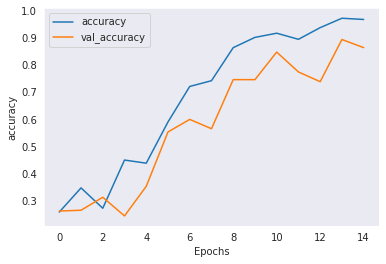

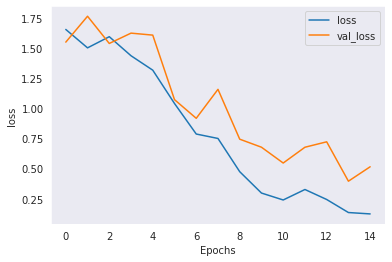

In [56]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [57]:
#Load tensorboard module
#%load_ext tensorboard
%reload_ext tensorboard
#Start tensorboard
%tensorboard --logdir 'logs/'
#%tensorboard --logdir MODEL_DIR


<IPython.core.display.Javascript object>

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [84]:
len(word_index)

19183

In [85]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(25000, 50)


In [86]:
vocab_size

18000

### Saving Word embeddings 

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')